## Task 1: Simulating a basic 8-bit binary counter

### Step 1: Create a folder for Lab 1 on your local disk for this lab session

- Fork the repository to your own GitHub account
- Clone the repository to your local disk

### Step 2: Run VS Code and open the Lab1-Counter folder
### Step 3: Create a new System Verilog file (counter.sv) and enter the code for counter

```Verilog
module counter #(
    parameter WIDTH = 8
)(
    // interface signals
    input logic                 clk,        // clock
    input logic                 rst,        // reset
    input logic                 en,         // counter enable
    output logic [WIDTH-1:0]    count       // count output 
);

always_ff @ (posedge clk)
    if (rst) count <= {WIDTH{1'b0}};
    else     count <= count + {{WIDTH-1{1'b0}}, en}; // count sequential add a input with WIDTH bits, whose first (WIDTH-1) bits == 0 and last bit == en

endmodule
```

### Step 4: Create the testbench file counter_tb.cpp 

```C++
#include "Vcounter.h"
#include "verilated.h"
#include "verilated_vcd_c.h"

int main(int argc, char **argv, char ** env){
    int i; //count the number of clock cycles to simulate
    int clk; //the module signal

    Verilated::commandArgs(argc, argv);
    // init top veerylog instance
    Vcounter* top = new Vcounter;
    // init trace dump
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace (tfp, 99);
    tfp->open("counter.vcd");
    
    //initialize simulation inputs
    top->clk = 1;
    top->rst = 1;
    top->en = 0;

    //run simulation for many clock cycles
    for (i=0; i<300; i++){              //in for loop the simulation happens

        //dump variables into VCD file and toggle clock
        for (clk=0; clk<2; clk++){
            tfp->dump (2*i+clk);        //unit is in ps!!!
            top->clk = !top->clk;
            top->eval();
        }
        top->rst = (i<2) | (i == 15);   //change reset in simulation
        top->en = (i>4);                //change en in simulation
        if (Verilated::gotFinish())  exit(0);  
    }
    tfp->close();
    exit(0);
}
```

### Step 5: Compile the System Verilog model with the testbench
```
# run Verilator to translate Verilog into C++, including C++ testbench
verilator -Wall --cc --trace counter.sv --exe counter_tb.cpp
```
This runs Verilator to translate `counter.sv` into C++ code, and merge with `counter_tb.cpp` to produce a number of the files in a new folder: `obj.dir`. It also automatically generates a `.mk` file called `Vcounter.mk`, which will produce the final simulation model `Vcounter`

```
# build C++ project via make automatically generated by Verilator
make -j -C obj_dir/ -f Vcounter.mk Vcounter
```
This makes `Vcounter`, which is the executable model of our counter! 
```
# run executable simulation file
obj_dir/Vcounter
```
Now we can simulate by simply running `Vcounter`, which is again in the `obj_dir/` directory

The waveform is shown as follows: 
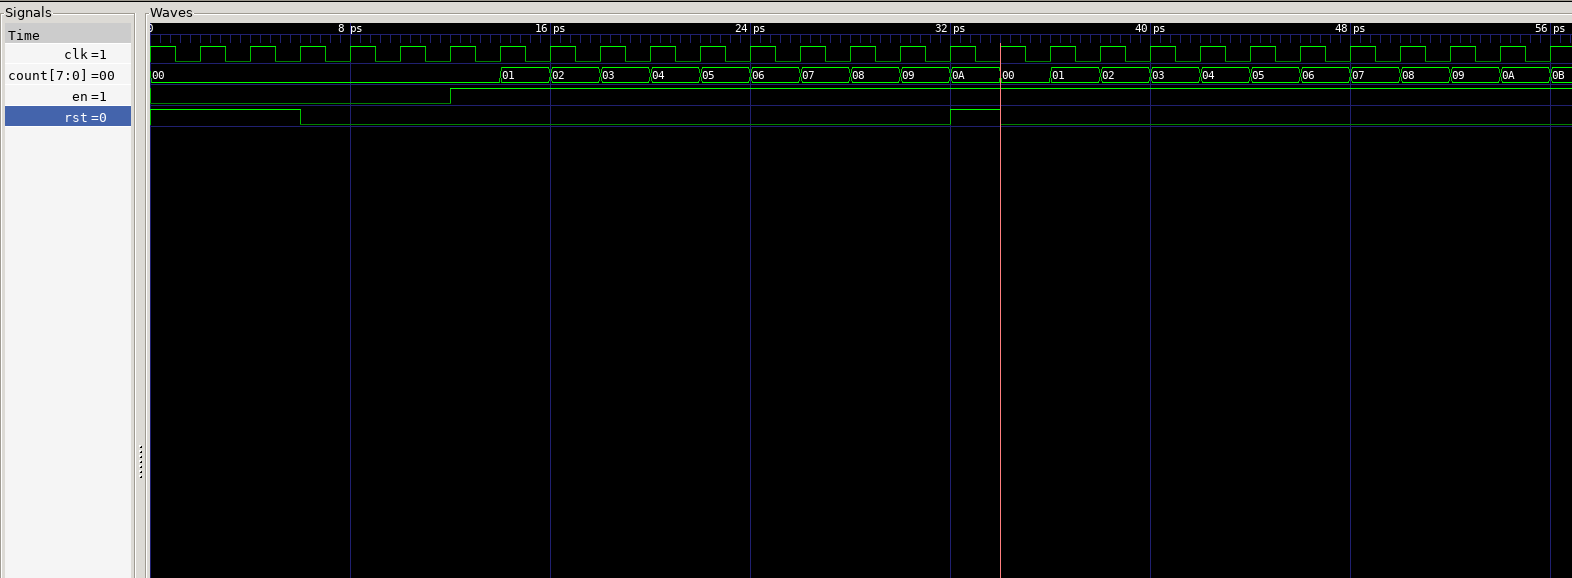

#### 6.1 Shortcut
To avoid retyping, create a shell script `doit.sh` that contains the following lines: 

``` 
#!/bin/sh

# cleanup
rm -rf obj_dir
rm -f counter.vcd

#run Verilator to translate Verilog to C++, including C++ testbench
verilator -Wall --cc --trace counter.sv --exe counter.cpp

#build C++ project via make automatically generated by Verilator
make -j -C obj_dir/ -f Vcounter.mk Vcounter

#run executable simulation file
obj_dir/Vcounter
```

The commands can be run in one go by typing
```
source ./doit.sh
```

### Step 7: Challenge

#### 7.1 Modify the testbench so that you stop counting for 3 cycles once the counter reaches 0X9, and then resume counting. You may also need to change the stimulus for rst. 

#### 7.1.1 Solution based on clock

```C++
#include "Vcounter.h"
#include "verilated.h"
#include "verilated_vcd_c.h"

int main(int argc, char **argv, char ** env){
    int i;
    int clk;

    Verilated::commandArgs(argc, argv);
    // init top veerylog instance
    Vcounter* top = new Vcounter;
    // init trace dump
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace (tfp, 99);
    tfp->open("counter.vcd");
    
    //initialize simulation inputs
    top->clk = 1;
    top->rst = 1;
    top->en = 0;

    //run simulation for many clock cycles
    for (i=0; i<300; i++){

        //dump variables into VCD file and toggle clock
        for (clk=0; clk<2; clk++){
            tfp->dump (2*i+clk);        //unit is in ps!!!
            top->clk = !top->clk;
            top->eval();
        }
        top->rst = (i<2); // | (i == 15);
        top->en = (i>4) && (i<15) || (i>17);

        if (Verilated::gotFinish())  exit(0);  
    }
    tfp->close();
    exit(0);
}
```

#### 7.1.2 Solution based on `top->count`
``` c++
#include "Vcounter.h"
#include "verilated.h"
#include "verilated_vcd_c.h"

int main(int argc, char **argv, char ** env){
    int i;
    int clk;

    Verilated::commandArgs(argc, argv);
    // init top veerylog instance
    Vcounter* top = new Vcounter;
    // init trace dump
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace (tfp, 99);
    tfp->open("counter.vcd");
    
    //initialize simulation inputs
    top->clk = 1;
    top->rst = 1;
    top->en = 0;
    int tag = -1;
    bool pulse = false;



    //run simulation for many clock cycles
    for (i=0; i<300; i++){

        //dump variables into VCD file and toggle clock
        for (clk=0; clk<2; clk++){
            tfp->dump (2*i+clk);        //unit is in ps!!!
            top->clk = !top->clk;
            top->eval();
        }
        if((top->count ==9) && (!pulse)){
            tag = i+3;
            pulse = true;
            
        }
        if (i == tag){
            pulse = false;
        }
        top->rst = (i<2); // | (i == 15);
        top->en = (i>4) && (!pulse);

        if (Verilated::gotFinish())  exit(0);  
    }
    tfp->close();
    exit(0);
}
```


#### 7.2 The current counter has a synchronous reset. To implement asynchronous reset, you can change line 11 of counter.sv file to detect change in rst signal. 
```Verilog
module counter #(
    parameter WIDTH = 8
)(
    // interface signals
    input logic                 clk,        // clock
    input logic                 rst,        // reset
    input logic                 en,         // counter enable
    output logic [WIDTH-1:0]    count       // count output 
);

always_ff @ (posedge clk, posedge rst)
    if (rst) count <= {WIDTH{1'b0}};
    else     count <= count + {{WIDTH-1{1'b0}}, en};

endmodule

```

## Task 2: Linking Verilator simulation with Vbuddy

### Step 1: Set up the Vbuddy interface

#### 1.1 Add Vbuddy to the port
Run Windows PowerShell as administrator <br>
Check the ports: `usbipd wsl list`<br>
Attach: `usbipd wsl attach ---busid <bus-id> --distribution Ubuntu-22.04` <br>
Confirm: `usbipd wsl list` <br>

![](<attachment:Screenshot 2023-10-26 104635.png>)


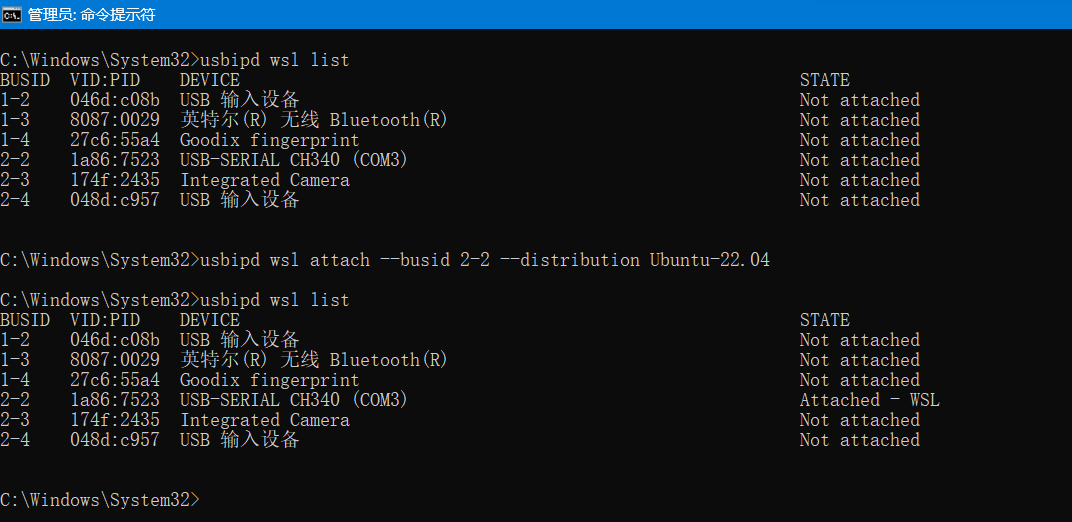

#### 1.2 Identidy the port Vbuddy use
Check attached: `lsusb` <br>
Check the device name: `dmesg | grep tty` or  `ls /dev/ttyUSB*` <br>
Name of the Vbuddy is `/dev/ttyUSB0` <br>

![](<attachment:Screenshot 2023-10-26 105018.png>)
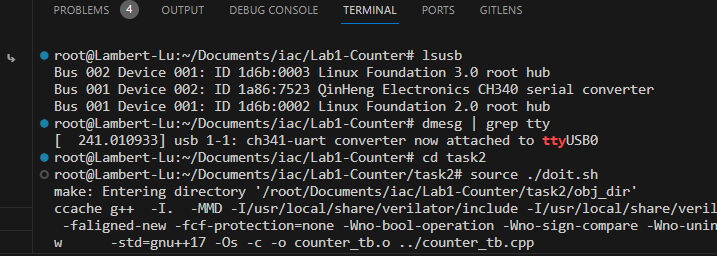

### Step 2: Modify testbench for Vbuddy

- Copy `counter.sv` and `counter_tb.cpp` to task2 folder
- Modify testbench file `count_tb.cpp` to include Vbuddy function (in the form `vbdXXX`)

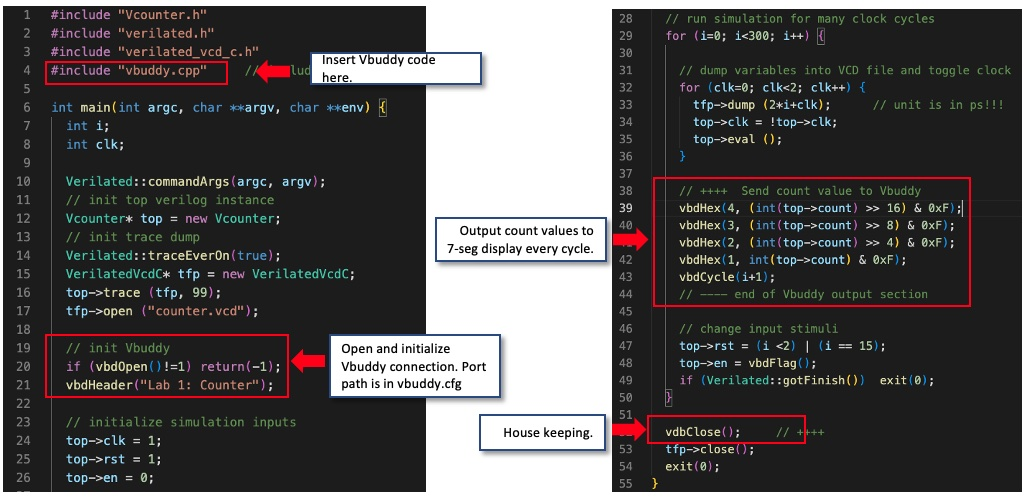

### Step 3: Explore flag feature on Vbuddy

#### 3.1 Use Flag to enable/disable counting 
- Vbuddy's rotary encode has a push-button switch. 
- Vbuddy keeps an internal flag which toggles between 0 and 1 each time the button is pressed. 
- The toggle switch state can be fetched by `vbdFlag()`

- The switch can be used to enable and disable the counter by modifying the testbench. 

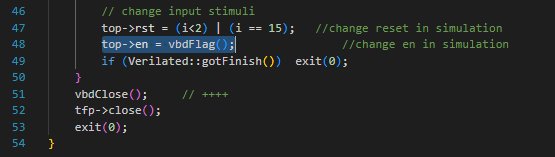

- Test result: When Flag is down: counting pause; when Flag is up: resume counting (from current value)

#### 3.2 Display the value by plotting

- Replace `vbdHex()` with `vbdPlot(int(top->count), 0, 255)`

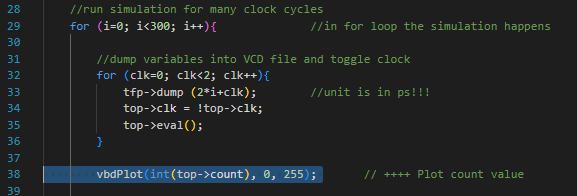

### Step 7: Challenge

Modify the counter and testbench files so that the `en` signal controls the direction of counting: '1' for up and '0' for down, via the `vbdFlag()` function

`counter.sv`
```Verilog
module counter #(
    parameter WIDTH = 8
)(
    // interface signals
    input logic                 clk,        // clock
    input logic                 rst,        // reset
    input logic                 en,         // counter enable
    output logic [WIDTH-1:0]    count       // count output 
);

always_ff @ (posedge clk)
    if (rst) count <= {WIDTH{1'b0}};
    else if (en)     count <= count + {{WIDTH-1{1'b0}}, 1'b1};
    else             count <= count - {{WIDTH-1{1'b0}}, 1'b1}; // change made here

endmodule
```

`counter_tb.cpp`
```c++
#include "Vcounter.h"
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "vbuddy.cpp"

int main(int argc, char **argv, char ** env){
    int i; //count the number of clock cycles to simulate
    int clk; //the module signal

    Verilated::commandArgs(argc, argv);
    // init top veerylog instance
    Vcounter* top = new Vcounter;
    // init trace dump
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace (tfp, 99);
    tfp->open("counter.vcd");
    
    //init Vbuddy
    if (vbdOpen()!=1) return(-1);
    vbdHeader("Lab 1: Counter");

    //initialize simulation inputs
    top->clk = 1;
    top->rst = 1;
    top->en = 0;

    //run simulation for many clock cycles
    for (i=0; i<300; i++){              //in for loop the simulation happens

        //dump variables into VCD file and toggle clock
        for (clk=0; clk<2; clk++){
            tfp->dump (2*i+clk);        //unit is in ps!!!
            top->clk = !top->clk;
            top->eval();
        }

        // ++++ Send count value to Vbuddy
        vbdPlot(int(top->count), 0, 255);       // ++++ Plot count value

        // ---- end of Vbuddy output section

        // change input stimuli
        top->rst = (i<2) | (i == 15);   //change reset in simulation
        top->en = vbdFlag();             //(i>4);   //change en in simulation
        if (Verilated::gotFinish())  exit(0);  
    }
    vbdClose();     // ++++
    tfp->close();
    exit(0);
}
```

## Task 3: Vbuddy parameter & Flag in one-shot mode

### Step 1: Loadable counter
- Copy `counter_tb.cpp`, `vbuddy.cpp`, `doit.sh`, and `vbuddy.cfg`
- Adapt a new `counter.sv`, which change `en` with `ld`

```verilog
module counter #(
  parameter WIDTH = 8
)(
  // interface signals
  input  logic             clk,      // clock 
  input  logic             rst,      // reset 
  input  logic             ld,       // load counter from data
  input  logic [WIDTH-1:0] v,        // value to preload
  output logic [WIDTH-1:0] count     // count output
);

always_ff @ (posedge clk)
  if (rst) count <= {WIDTH{1'b0}};
  else     count <= ld ? v : count + {{WIDTH-1{1'b0}},1'b1};
endmodule

```

#### 7.1 Two modes of Vbuddy's Flag
- `vbdSetMode(0)`: toddle between 0 and 1
- `vbdSetMode(1)`: One-shot behaviour, when switch is pressed, register set to 1 as before<br>
when flag register is read, immediate set to 0. 

> Modify `counter_tb.cpp` so that pressing the switch on EC11 forces the counter to pre-set to Vbuddy's parameter value. 

```c++
#include "Vcounter.h"
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "vbuddy.cpp"

int main(int argc, char **argv, char ** env){
    int i; //count the number of clock cycles to simulate
    int clk; //the module signal

    Verilated::commandArgs(argc, argv);
    // init top veerylog instance
    Vcounter* top = new Vcounter;
    // init trace dump
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace (tfp, 99);
    tfp->open("counter.vcd");
    
    //init Vbuddy
    if (vbdOpen()!=1) return(-1);
    vbdHeader("Lab 1: Counter");

    //initialize simulation inputs
    top->clk = 1;
    top->rst = 1;
    top->ld = 0;

    //run simulation for many clock cycles
    for (i=0; i<3000; i++){ 

        for (clk=0; clk<2; clk++){
            tfp->dump (2*i+clk); 
            top->clk = !top->clk;
            top->eval();
        }

        // ++++ Send count value to Vbuddy as curve
        vbdPlot(int(top->count), 0, 255);
        // ---- end of Vbuddy output section

        // change input stimuli
        vbdSetMode(1);                  //Set to One-Shot behaviour       
        top->rst = (i<2) | (i == 15); 
        top->ld = vbdFlag();            //Use the value of vbdFlag to set ld
        if (Verilated::gotFinish())  exit(0);  
    }
    vbdClose();     // ++++
    tfp->close();
    exit(0);
}
```

### Step 2: Single stepping
> Modify counter.sv so that you only increment the counter each time you press the switch

`counter.sv`
```verilog
module counter #(
  parameter WIDTH = 8
)(
  // interface signals
  input  logic             clk,      // clock 
  input  logic             rst,      // reset 
  input  logic             ld,       // load counter from data
  input  logic [WIDTH-1:0] v,        // value to preload
  output logic [WIDTH-1:0] count     // count output
);

always_ff @ (posedge clk)
  if (rst) count <= {WIDTH{1'b0}};
  // when ld = 1, count = count + 1, when ld = 0, count = count 
  else     count <= ld ? count + {{WIDTH-1{1'b0}},1'b1} : count; 
endmodule

```

`counter_tb` (no change is made)
```c++
#include "Vcounter.h"
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "vbuddy.cpp"

int main(int argc, char **argv, char ** env){
    int i; //count the number of clock cycles to simulate
    int clk; //the module signal

    Verilated::commandArgs(argc, argv);
    // init top veerylog instance
    Vcounter* top = new Vcounter;
    // init trace dump
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace (tfp, 99);
    tfp->open("counter.vcd");
    
    //init Vbuddy
    if (vbdOpen()!=1) return(-1);
    vbdHeader("Lab 1: Counter");

    //initialize simulation inputs
    top->clk = 1;
    top->rst = 1;
    top->ld = 0;

    //run simulation for many clock cycles
    for (i=0; i<3000; i++){ 

        for (clk=0; clk<2; clk++){
            tfp->dump (2*i+clk); 
            top->clk = !top->clk;
            top->eval();
        }

        // ++++ Send count value to Vbuddy as curve
        vbdPlot(int(top->count), 0, 255);
        // ---- end of Vbuddy output section

        // change input stimuli
        vbdSetMode(1);                  //Set to One-Shot behaviour       
        top->rst = (i<2) | (i == 15); 
        top->ld = vbdFlag();            //Use the value of vbdFlag to set ld
        if (Verilated::gotFinish())  exit(0);  
    }
    vbdClose();     // ++++
    tfp->close();
    exit(0);
}
```

## Task 4: Displaying count as Binary Coded Decimal (BCD) numbers

> Create a top-level module (`top.sv`), which has the counter module and a second module that converts the 8-bit binary number into three BCD digits. 
> Modify the testbench file `top_tb.cpp` accordingly
> Modify the `doit.sh` file from task 3 to include all the modules (`top.sv`, `counter.sv`, `bin2bcd.sv` and `top_tb.sv`)
```verilog
module top #(
  parameter WIDTH = 8
)(
  // interface signals
  input  logic             clk,      // clock 
  input  logic             rst,      // reset 
  input  logic             en,       // enable
  input  logic [WIDTH-1:0] v,        // value to preload
  output logic [11:0]      bcd       // count output
);

  logic  [WIDTH-1:0]       count;    // interconnect wire

counter myCounter (
  .clk (clk),
  .rst (rst),
  .en (en),
  .count (count)
);

bin2bcd myDecoder (
  .x (count),
  .BCD (bcd)
);

endmodule
```